<a href="https://colab.research.google.com/github/RedSnyper/AmenityDetection/blob/main/DataPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#COCO
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!rm annotations_trainval2017.zip
!wget http://images.cocodataset.org/annotations/image_info_test2017.zip
!unzip image_info_test2017.zip


#OPENIMAGES
!wget -O train-annotations-bbox.csv https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv 

!wget -O val-annotations-bbox.csv https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv

!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

!wget -O train-images-with-rotation.csv https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv

!wget -O val-images-with-rotation.csv https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv

!wget https://storage.googleapis.com/openimages/2018_04/test/test-images-with-rotation.csv

--2022-07-09 13:53:56--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.41.73
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.41.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  45.2MB/s    in 5.7s    

2022-07-09 13:54:02 (42.3 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  
--2022-07-09 13:54:09--  http://images.cocodataset.org/annotations/image

In [ ]:
import os
import cv2
import csv
import json
import tqdm
import random
import requests
import imagesize
import urllib.request
import concurrent.futures
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import notebook
from time import perf_counter
from abc import ABC, abstractmethod
from matplotlib.pyplot import figure
from collections import Counter
from pathlib import Path
count = 0 #for annotation ids

In [ ]:
class Dataset(ABC):

  @abstractmethod
  def download_dataset(self): #type hint for returning csv or json file? 
    raise NotImplementedError("Method not implemented")

  @abstractmethod
  def load_dataset(self):
    raise NotImplementedError("Method not implemented")
  
  @abstractmethod
  def keep_specific_annotations(self):
    raise NotImplementedError("Method not implemented")

  @abstractmethod
  def visualize_dataset(self):
    raise NotImplementedError("Method not implemented")

  @abstractmethod
  def download_images_thread(self):
    raise NotImplementedError("Method not implemented")

  @abstractmethod
  def to_coco(self):
    raise NotImplementedError("Method not implemented")

  @classmethod
  def download_images(cls,img_detail:tuple):
      #TODO keep record of all failed images and remove the info from datasets
      img_url, filename = img_detail[0], img_detail[1]
      res = requests.get(img_url)
      if res.status_code == 200:
        filepath = Path(filename)
        filepath.parent.mkdir(parents=True, exist_ok=True)
        with filepath.open("wb") as f:
            f.write(res.content)

  @staticmethod           #static not class as draw_plot is used elsewhere too. Would be better if this is out of the class into its own function
  def draw_plot(label: str,annotation_counts: dict, name:str):
    print("OCCURANCES")
    for key,value in list(annotation_counts.items()):
      if value==0:
        del annotation_counts[key]
        continue
      print(f'{key}------------------>{value}')
    plt.figure(figsize=(20,8))
    plt.title(f'{name.upper()}: {label} dataset', fontdict = dict(fontsize=30))
    plt.xlabel("amenities",fontdict=dict(fontsize=20))
    plt.ylabel("count",fontdict=dict(fontsize=20))
    plt.bar(*zip(*annotation_counts.items()))
    for i, v in enumerate(annotation_counts.values()):
      plt.text(i,v,v,fontdict=dict(fontsize=15), ha='center')
    plt.show()


  @staticmethod
  def place_json_file(label:list, dataset: dict, name: str, root = "data"):
    json_folder = os.path.join(root,label)
    json_file = os.path.join(json_folder, f'{label}_{name}.json')
    filepath = Path(json_file)
    filepath.parent.mkdir(parents=True, exist_ok=True)
    with filepath.open("w") as f:
        print(f'\nmaking {label} json file in {f.name}')
        json.dump(dataset, f)

In [ ]:
class COCODataset(Dataset):
    def __init__(self, labels: list, amenities_mapping: dict, root: str = "data" ):
      self.root = root
      self.dataset = dict()
      self.labels = labels
      self.amenities_mapping = amenities_mapping     #ground truth of amenities and its id
      self.amenities: list = amenities_mapping.keys()
      for label in labels:
        self.dataset[label] = dict()

    #TODO use subprocess python module instead of linux command
    def download_dataset(self) -> None:
        pass

    def load_dataset(self):
      for label in self.labels:
        filename = f'annotations/instances_{label}2017.json' 
        with open(filename) as f:
          print(f'Loading {filename} into memory')
          start = perf_counter()
          self.dataset[label] = json.load(f)
          end = perf_counter()
          print(f"Loaded the file in {end-start:.2f} seconds")

    def _generate_mapping(self):
        category_dict = {cats['name']:cats['id'] 
                        for cats in self.dataset["val"]["categories"]} #categories are same for train, val, test
        req_keys = [category_dict[item] for item in 
                    set(self.amenities_mapping.keys()).intersection(category_dict.keys())]
        category_dict = {key:value for value, key in category_dict.items()}
        return (req_keys, category_dict) 


    def keep_specific_annotations(self) -> dict:
        global count
        req_keys, category_dict = self._generate_mapping()
        for label in self.labels:
          print(f"processing {label} dataset....\n")
          categories = list()
          annotations = list()
          images = list()
          print(f'Categories before: {len(self.dataset[label]["categories"])}')    
          print(f'Annotations before: {len(self.dataset[label]["annotations"])}')  
          print(f'Images before: {len(self.dataset[label]["images"])}')  


          for cats in self.dataset[label]['categories']:
            if cats['name'] in self.amenities_mapping.keys():
              cats['id'] = self.amenities_mapping[cats['name']]
              del cats['supercategory']
              categories.append(cats)

          for anns in self.dataset[label]['annotations']:
            if anns['category_id'] in req_keys:
              del anns['segmentation'] #for object detection, seg not necessary.Saving memory
              del anns['iscrowd']
              del anns['area']
              anns['bbox_mode'] = 1
              anns['category_id'] = self.amenities_mapping[category_dict[anns['category_id']]]
              anns['image_id'] = str(anns['image_id'])
              anns['id'] = count
              count += 1
              annotations.append(anns)
          
          img_ids = [data['image_id'] for data in annotations]

          for imgs in self.dataset[label]["images"]:
            if str(imgs['id']) in img_ids:
              del imgs['license']
              del imgs['date_captured']
              del imgs['flickr_url']
              imgs['id'] = str(imgs['id'])
              images.append(imgs)

          del self.dataset[label]['annotations'] #removes old annotations. Releases big chunck of memory.
          del self.dataset[label]['categories']
          del self.dataset[label]['images']
          del self.dataset[label]['info']
          del self.dataset[label]['licenses']

          self.dataset[label]['annotations'] = annotations
          self.dataset[label]['categories'] = categories
          self.dataset[label]['images'] = images

          print(f'Categories after keeping only required: {len(self.dataset[label]["categories"])}')    
          print(f'Annotations after keeping only required: {len(self.dataset[label]["annotations"])}')    
          print(f'Images after keeping only required: {len(self.dataset[label]["images"])}\n')

    def visualize_dataset(self):
      from collections import Counter
      for label in self.labels:
        counter = Counter()
        for data in self.dataset[label]['annotations']:
          counter.update([data["category_id"]])
        for k, v in self.amenities_mapping.items():
          counter[k] = counter[v]
          del counter[v]
        Dataset.draw_plot(label, counter, "coco")

    def download_images_thread(self):
      for label in self.labels:
        im_folder = os.path.join(self.root, label)
        images = self.dataset[label]['images']
        with tqdm.tqdm(total=len(images), desc=f'downloading images for {label}') as pbar:
          with concurrent.futures.ThreadPoolExecutor(len(images)) as executor:
            for imgs in images:
                im_path = os.path.join(im_folder, imgs['file_name'])
                if not os.path.exists(im_path):
                  executor.submit(super().download_images, (imgs['coco_url'],im_path))
                del imgs['coco_url']
                pbar.update(1)

    def to_coco(self):
      pass

    def place_json_file(self):
      for label in self.labels:
        Dataset.place_json_file(label=label, dataset=self.dataset[label], name="coco", root=self.root)

In [ ]:
class OpenImages(Dataset):
    def __init__(self, labels: list, amenities_mapping: dict, root: str = "data" ):
      self.root = root
      self.dataset = dict()
      self.imgset = dict()
      self.labels = labels
      self.amenities_mapping = amenities_mapping 
      self.amenities:list = amenities_mapping.keys()
      for label in labels:
        self.dataset[label] = dict()
        self.imgset[label] = dict()
      self.amenities_labels = dict()

    #TODO use subprocess python module instead of linux command
    def download_dataset(self) -> None:
        pass


    def load_dataset(self):
      for label in self.labels:
        #load bbox csv files
        print(f'Loading {label} annotations csv into memory...')
        self.dataset[label] = pd.read_csv(f'{label}-annotations-bbox.csv')
        print("done")
        #load image csv files
        print(f'Loading {label} image csv into memory...')
        self.imgset[label] = pd.read_csv(f'{label}-images-with-rotation.csv')
        print("done\n")

      #load label dataset
      print("loading class-label csv file")
      with open("class-descriptions-boxable.csv") as file:
        reader = csv.reader(file)
        for row in reader:
          if row[0] == "/m/03wvsk":
            row[1] = "hair drier"
          if row[1].lower() in self.amenities:
            self.amenities_labels.update({row[0]: row[1].lower()})

    def keep_specific_annotations(self):
      for label in self.labels:
        print(f'Annotations info in {label} before: {len(self.dataset[label])}')
        self.dataset[label] = self.dataset[label].loc[
                  self.dataset[label]['LabelName'].isin(self.amenities_labels.keys())]
        
        assert len(self.dataset[label]) > 0, f"Annotation for some amenity does not exist in {label} dataset"
        
        print(f'Annotations info in {label} after: {len(self.dataset[label])} \n')

        print(f'Images info in {label} before: {len(self.imgset[label])}')
        img_ids = self.dataset[label]['ImageID']
        self.imgset[label] = self.imgset[label].loc[self.imgset[label]["ImageID"].isin(img_ids)]
        print(f'Images info in {label} after: {len(self.imgset[label])} \n')

    def visualize_dataset(self):
      from collections import Counter
      for label in self.labels:
        c = Counter()
        c.update(self.dataset[label]["LabelName"])
        images_count = dict()
        for key, value in c.items():
          images_count[self.amenities_labels[key]] = value
        super().draw_plot(label, images_count, "open images")


    def download_images_thread(self):
      for label in self.labels:
        im_folder = os.path.join(self.root, label)
        images = self.imgset[label]
        with tqdm.tqdm(total=len(images), desc=f'downloading images for {label}') as pbar:
          with concurrent.futures.ThreadPoolExecutor(len(images)) as executor:
            for imgs in images.to_numpy():
                im_path = os.path.join(im_folder, imgs[0])
                im_path = f'{im_path}.jpg'
                if not os.path.exists(im_path):
                  executor.submit(super().download_images, (imgs[2],im_path))
                pbar.update(1)


    def to_coco(self):
      global count
      for label in self.labels: 
        records = []
        images = []
        annotations = []
        categories = []

        for key, value in self.amenities_labels.items():
          category = {"id" : self.amenities_mapping[self.amenities_labels[key]], 
                      "name" :value}
          categories.append(category)
      
        for img_file in tqdm.notebook.tqdm(Path(f'{self.root}/{label}').glob("*.jpg"), 
                                           desc = f'Converting to COCO format for {label} datset'):
          imgs = {}
          anns = {}
          file_name = img_file.name
          id = file_name.split('.')[0]
          if id.isnumeric():  #the numeric are of only coco which are already in dataset
            continue
          width,height = imagesize.get(img_file) #using imagesize instead of cv2. Insane speed up
          imgs["file_name"] = file_name
          imgs["id"] = id
          imgs["width"] = width
          imgs["height"] = height
          images.append(imgs)
          ##################################################################
          datas = self.dataset[label][self.dataset[label]["ImageID"] == id] #many entries for same image id can exist
          # count += 1
          for data in datas.to_numpy():
            category_id = self.amenities_mapping[self.amenities_labels[data[2]]]
            xmin= data[4] * width
            xmax = data[5] * width
            ymin = data[6] * height
            ymax = data[7] * height
            dx = xmax - xmin
            dy = ymax - ymin
            anns["image_id"] = id
            anns["bbox"] = [round(a, 2) for a in [xmin , ymin, dx, dy]] #XYWH format
            anns["bbox_mode"] = 1
            anns["category_id"] = category_id
            anns['id'] = count
            count += 1
            annotations.append(anns)
            anns = {} 
        self.dataset[label] = dict() #removing the panads dataframe entirely
        self.dataset[label]["images"] = images
        self.dataset[label]['annotations'] = annotations
        self.dataset[label]['categories'] = categories  

    def place_json_file(self):
      for label in self.labels:
        super().place_json_file(label=label, dataset=self.dataset[label], name="oi", root=self.root)


In [ ]:
class DatasetFactory():
    def __init__(self,source:str,labels:list,root:str,amenities:list ):
      self.amenities_mapping = {value:key for key, value in enumerate(sorted(amenities))}
      self.labels = labels
      self.root = root
      if source == "coco":
        if "test" in self.labels: 
          self.labels.remove('test')
            #COCO dataset test label is just for predicting images. Has no annotations, 
            #no label,so is useless for our use case.
        self._dataset = COCODataset(self.labels, self.amenities_mapping, self.root)
      elif source == "oi":
        self._dataset = OpenImages(self.labels, self.amenities_mapping, self.root)
      else:
        raise NotImplementedError(f"dataset source: {source} has not been implemented")

    @property
    def dataset(self):
      return self._dataset.dataset 
                #_dataset = property of DatasetFactory #dataset = property of COCODataset/OpenImages

    @property
    def factory(self):
      return self._dataset #returns the factory(source)


    def generate(self):
      """
      Generates the dataset in one go. 
      """
      self._dataset.load_dataset()
      self._dataset.keep_specific_annotations()
      self._dataset.visualize_dataset()
      self._dataset.download_images_thread()
      self._dataset.to_coco()
      self._dataset.place_json_file()

    def __add__(self, other):
      if isinstance(other, DatasetFactory):
        for ds in self.dataset.keys():
          merged_dataset[ds] = {}
          if ds == "test":  #coco test dataset is not included
            continue
          for keys in self.dataset[ds].keys():
            data = self.dataset[ds][keys] + other.dataset[ds][keys]
            if keys == "categories": #this is the only thing that is repeated
              data = [dict(t) for t in {tuple(d.items()) for d in data}]
            merged_dataset[ds][f'{keys}'] = data

            #one way to save memory is to extend the existing list (coco or oi) with its respective list from another dataset(coco or oi)
          
        return merged_dataset
      else:
        raise TypeError("invalid type")  

    @staticmethod
    def visualise_dataset(dataset, amenities,plot_title):
        amenities_mapping = {value:key for key, value in enumerate(sorted(amenities))}
        from collections import Counter
        for label in dataset.keys():
          counter = Counter()
          for data in dataset[label]['annotations']:
            counter.update([data["category_id"]])
          for k, v in amenities_mapping.items():
            counter[k] = counter[v]
            del counter[v]
          Dataset.draw_plot(label, counter, plot_title)

    @staticmethod
    def limit_annotation_count(dataset, limit = 1000):
      from collections import Counter
      for label in dataset.keys():
        annotations = []
        counter = Counter()
        for data in dataset[label]['annotations']:
          if counter.get(data['category_id'],0) >= limit:
            continue
          counter.update([data["category_id"]])
          annotations.append(data)
        del dataset[label]["annotations"]
        dataset[label]["annotations"] = annotations
        #TODO remove images having no annotations
      DatasetFactory.visualise_dataset(dataset, amenities, "Merged(Limited)")

    @staticmethod
    def remove_unused_images(dataset):
      for label in dataset.keys():
        images = []
        print(label)
        print(f'Images before: {len(dataset[label]["images"])}')  
        img_ids = [data['image_id'] for data in dataset[label]["annotations"]]
        for imgs in dataset[label]["images"]:
          if imgs['id'] in img_ids:
            images.append(imgs)
          else:
            if len(str(imgs['id'])) <= 7:    # hack to know this is coco id, img never exceeds 6 digits (9*10*10*10*10*10=900k, coco has 330k)
                                             # len(7) just for safeguard.
              zeros = '0' * (12-len(str(imgs['id']))) #coco specific
              filename = f"{zeros}{imgs['id']}.jpg"
            else:
              filename = f"{imgs['id']}.jpg"
            file_path = os.path.join("data",label, filename)  
            if os.path.exists(file_path):
              os.remove(file_path)
        del dataset[label]["images"]
        dataset[label]["images"] = images
        print(f'Images after: {len(dataset[label]["images"])}')  

    @staticmethod
    def place_json_file(dataset, root):
      for label in dataset.keys():
        json_file = os.path.join(root, label, f'{label}.json')
        filepath = Path(json_file)
        filepath.parent.mkdir(parents=True, exist_ok=True)
        with filepath.open("w") as f:
            print(f'Making {label} json file in {f.name}')
            json.dump(dataset[label], f)



Loading annotations/instances_train2017.json into memory
Loaded the file in 17.31 seconds
Loading annotations/instances_val2017.json into memory
Loaded the file in 0.52 seconds
processing train dataset....

Categories before: 80
Annotations before: 860001
Images before: 118287
Categories after keeping only required: 2
Annotations after keeping only required: 423
Images after keeping only required: 406

processing val dataset....

Categories before: 80
Annotations before: 36781
Images before: 5000
Categories after keeping only required: 2
Annotations after keeping only required: 20
Images after keeping only required: 17

OCCURANCES
hair drier------------------>198
toaster------------------>225


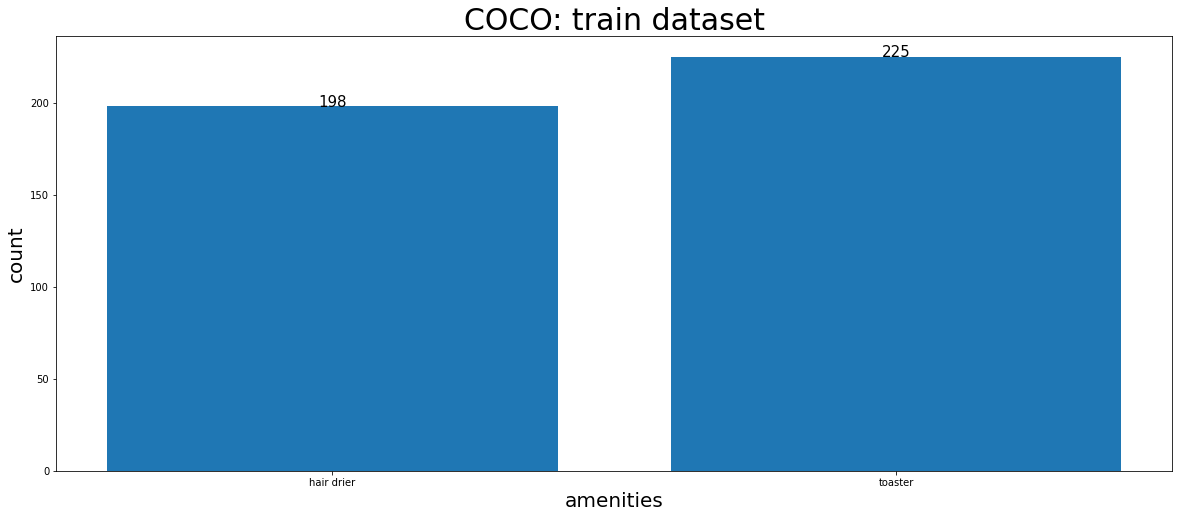

OCCURANCES
hair drier------------------>11
toaster------------------>9


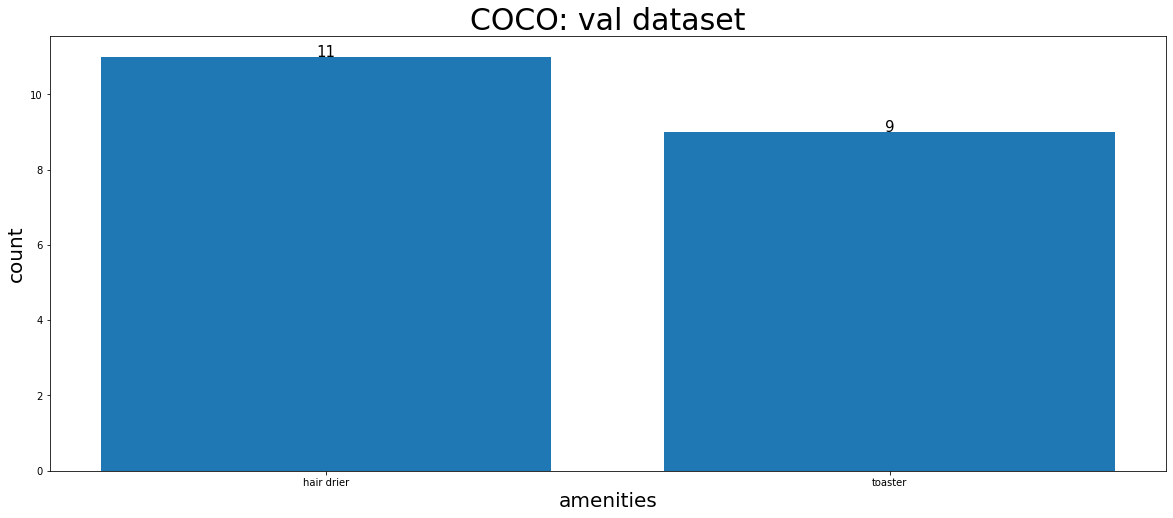

downloading images for val: 100%|██████████| 17/17 [00:00<00:00, 6843.57it/s]


making train json file in data/train/train_coco.json

making val json file in data/val/val_coco.json
Loading train annotations csv into memory...


done
Loading train image csv into memory...
done

Loading val annotations csv into memory...
done
Loading val image csv into memory...
done

loading class-label csv file
Annotations info in train before: 14610229
Annotations info in train after: 100 

Images info in train before: 1743042
Images info in train after: 87 

Annotations info in val before: 303980
Annotations info in val after: 1 

Images info in val before: 41620
Images info in val after: 1 

OCCURANCES
toaster------------------>73
hair drier------------------>27


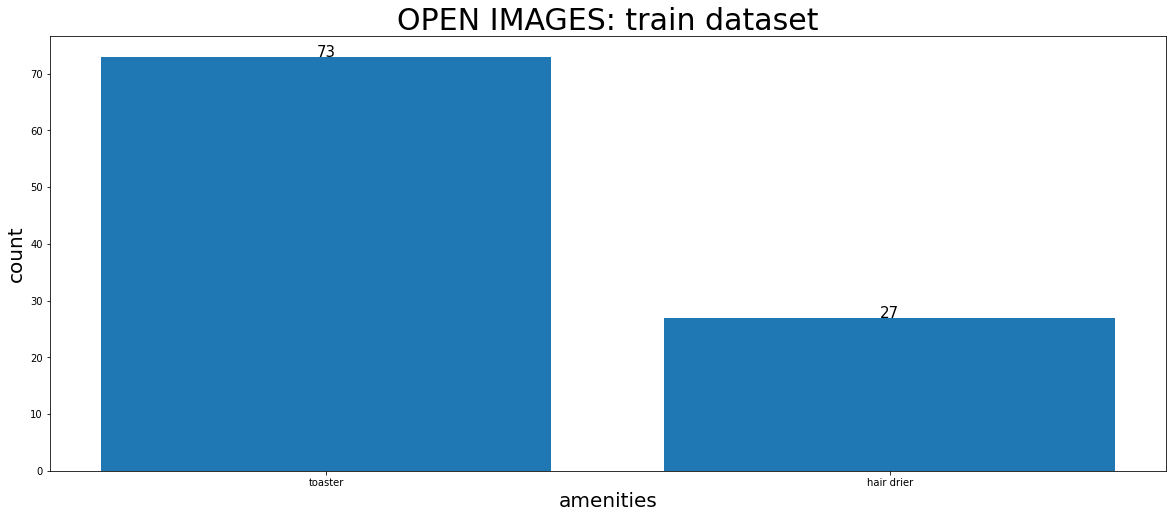

OCCURANCES
toaster------------------>1


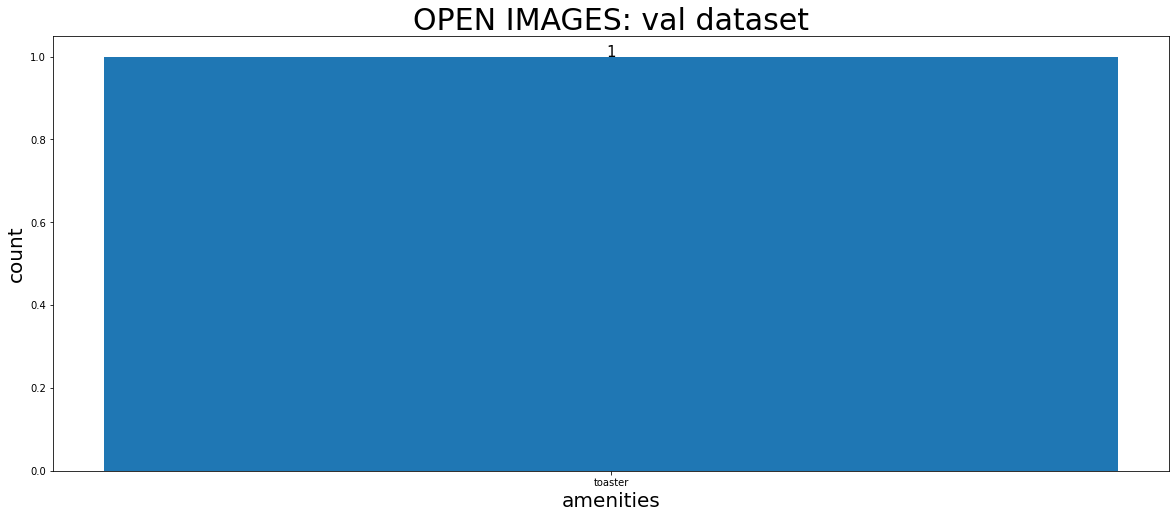

downloading images for val: 100%|██████████| 1/1 [00:00<00:00, 1116.40it/s]


Converting to COCO format for train datset: 0it [00:00, ?it/s]

Converting to COCO format for val datset: 0it [00:00, ?it/s]


making train json file in data/train/train_oi.json

making val json file in data/val/val_oi.json
For train
Before Merging
COCO: Images = 406, COCO: Annotations 423
Open Images: Images = 78, Open Images: Annotations 90
After Merging
Merged: Images = 484, COCO: Annotations 513

For val
Before Merging
COCO: Images = 17, COCO: Annotations 20
Open Images: Images = 2497, Open Images: Annotations 1
After Merging
Merged: Images = 2514, COCO: Annotations 21

OCCURANCES
hair drier------------------>223
toaster------------------>290


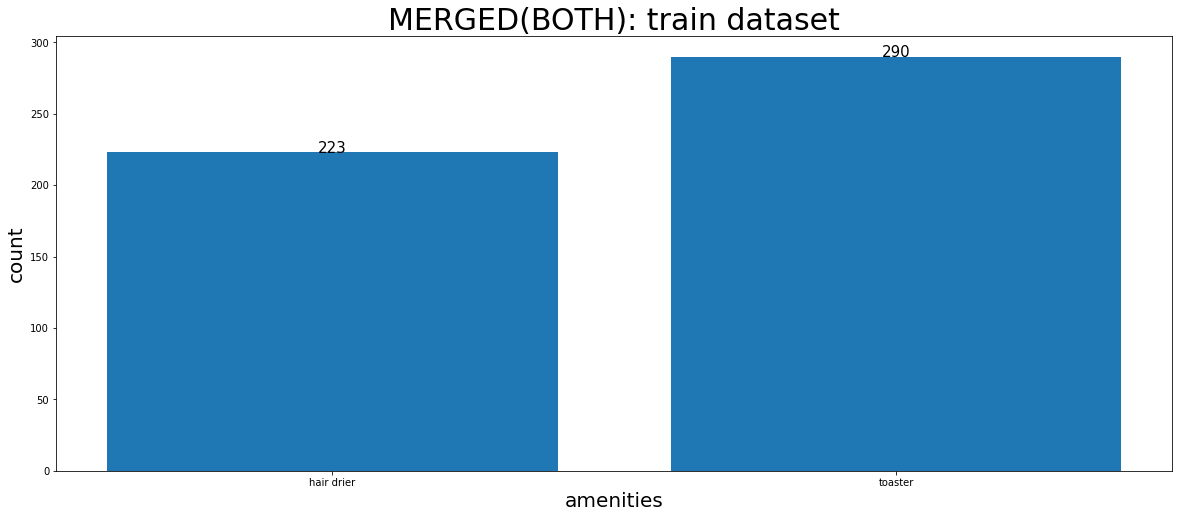

OCCURANCES
hair drier------------------>11
toaster------------------>10


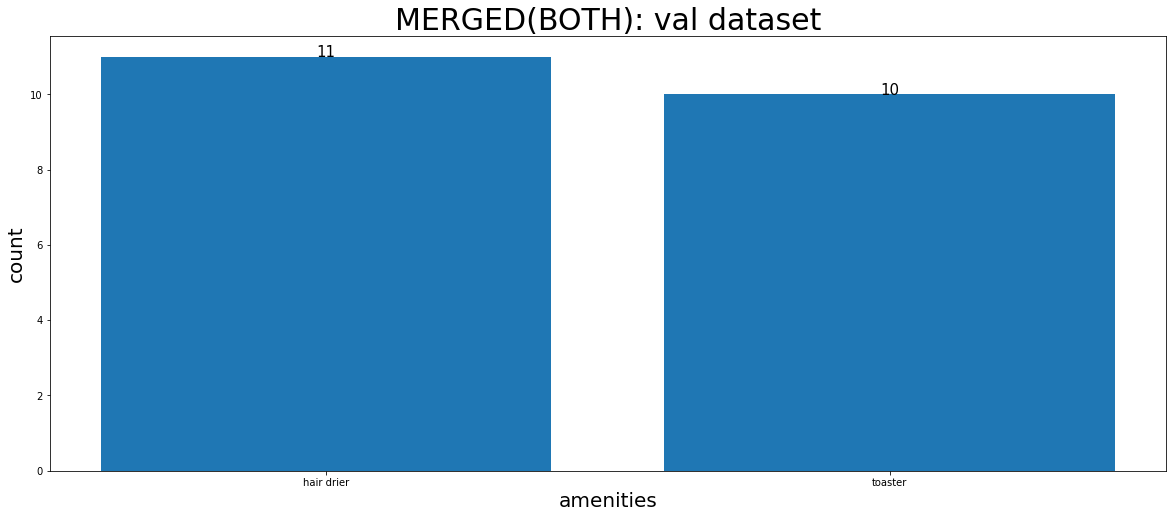

Making train json file in data/train/train.json
Making val json file in data/val/val.json
Making train json file in merged_data/train/train.json
Making val json file in merged_data/val/val.json


In [ ]:
if __name__ == "__main__": 
  # amenities = ['hair drier', 'refrigerator', 'sink','toaster','oven', 'microwave','toilet','dining table', 'couch', 'chair', 'bench', 'bed', 'potted plant','tv', 'alarm clock', 'closet']
  amenities = ['hair drier', "toaster"]
  labels = ["train","val"]
  cocofactory = DatasetFactory("coco",labels,"data", amenities)
  oifactory = DatasetFactory("oi",labels,"data", amenities)
  cocofactory.generate()
  oifactory.generate()
  merged_dataset = dict()
  merged_dataset = cocofactory + oifactory
  for label in labels:
    print(f'For {label}')
    print('Before Merging')
    print(f'COCO: Images = {len(cocofactory.dataset[label]["images"])}, COCO: Annotations {len(cocofactory.dataset[label]["annotations"])}')
    print(f'Open Images: Images = {len(oifactory.dataset[label]["images"])}, Open Images: Annotations {len(oifactory.dataset[label]["annotations"])}')
    print("After Merging")
    print(f'Merged: Images = {len(merged_dataset[label]["images"])}, COCO: Annotations {len(merged_dataset[label]["annotations"])}\n')

  DatasetFactory.visualise_dataset(merged_dataset, amenities, "Merged(Both)")
  # DatasetFactory.limit_annotation_count(merged_dataset, 200)
  # DatasetFactory.remove_unused_images(merged_dataset)
  DatasetFactory.place_json_file(merged_dataset, "data")
  DatasetFactory.place_json_file(merged_dataset, "merged_data") #redundancy for easy finding of the file :P 



#Remaining work : 1) use requests and zipfile maybe 
#                 2) Remove all unused downloaded files to free space